# Отток клиентов из банка

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 



## Цель проекта

Необходимо построить модель, которая будет прогнозировать уйдёт ли клиент из банка в ближайшее время или нет. Метрика качества модели - *F1*. Чтобы сдать проект успешно, нужно довести метрику до 0,59.

## План работы

1. Загрузка данных.
2. Предварительная обработка данных.
3. Подготовка обучающих выборок.
4. Обучение моделей на несбалансированных данных.
5. Борьба с дисблансом классов.
6. Обучение моделей на сбалансированных данных.
7. Проверка лучшей модели на тестовой выборке.

## Описание данных

Признаки

- **RowNumber** — индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — сколько лет человек является клиентом банка
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты
- **IsActiveMember** — активность клиента
- **EstimatedSalary** — предполагаемая зарплата

Целевой признак

- **Exited** — факт ухода клиента

## Подготовка данных

### Настройка окружения

In [1]:
# установим библиотеку skimpy, для работы с заголовками столбцов и спрячем репорт об установке
!pip install skimpy -q

In [2]:
# основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimpy import clean_columns
import matplotlib.pyplot as plt

# подготовка к машинному обучению
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# модели машинного обучения
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# метрики машинного обучения
from sklearn.metrics import (f1_score, roc_auc_score)
from sklearn.metrics import accuracy_score

import shap

### Загрузка данных и изучение данных

In [3]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/Churn.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
# посмотрим размерность таблицы
df.shape

(10000, 14)

In [5]:
# общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# посмотри на данные вживую
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3204,3205,15603942,Hawthorn,547,Germany,Male,50,3.0,81290.02,3,0,1,177747.03,1
4603,4604,15671172,Swain,623,France,Male,23,1.0,106012.20,2,0,1,191415.94,0
8260,8261,15627830,Nikitina,640,Germany,Female,30,5.0,32197.64,1,0,1,141446.01,0
7824,7825,15761149,Teng,673,France,Female,44,8.0,133444.97,1,0,1,5708.19,0
7530,7531,15711299,Wilson,711,Germany,Female,52,8.0,145262.54,1,0,1,131473.31,0


Данные загружены без ошибок. Датафрейм имеет 14 столбцов и 10 000 строк. 

### Предобработка данных.

In [7]:
# изучим название столбцов
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [8]:
# приведем названия к змеиному стилю
df = clean_columns(df)

# проверим
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [9]:
# проверим на явные дубликаты
df.duplicated().sum()

0

Явные дубликаты отсутствуют.

In [10]:
# проверим на неявные дубликаты по столбцу 'customer_id'
df.duplicated(subset=['customer_id']).sum()

0

Неявные дубликаты в столбце 'customer_id' отстуствуют.

In [11]:
# проверим пропуски данных
df.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [12]:
# посмотрим сколько процентов составляют пропуски от общего количества данных
100 * df.isna().sum() / df.shape[0]

row_number          0.00
customer_id         0.00
surname             0.00
credit_score        0.00
geography           0.00
gender              0.00
age                 0.00
tenure              9.09
balance             0.00
num_of_products     0.00
has_cr_card         0.00
is_active_member    0.00
estimated_salary    0.00
exited              0.00
dtype: float64

В столбце 'tenure' присуствую пропуски, в количестве 909 строк, порядка 9.1 %.

In [13]:
# посмотрим среднее и медианное значения по столбцу 'tenure'
df['tenure'].mean(), df['tenure'].median()

(4.997690023099769, 5.0)

Среднее и медиана практически совпадают.

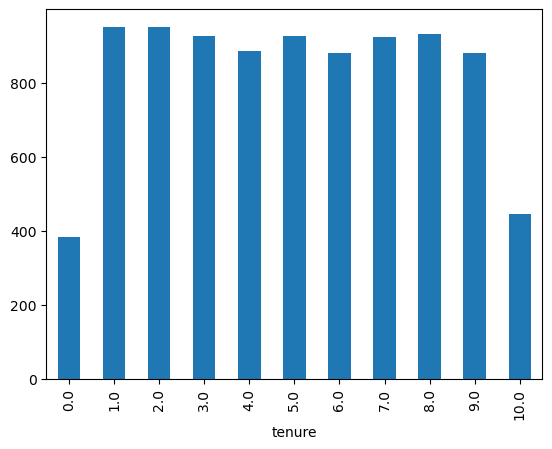

In [14]:
# посмотри распределение значений по столбцу 'tenure'
df['tenure'].value_counts().sort_index().plot.bar();

По результатм изучения столбца 'tenure', можно сделать следующие выводы:


- Возможно пропуски в данном столбце связанны с тем, что данное поле не было заполнено для новых клиентов банка, которые являются таковыми менее года, по такой логике пропуски можно заполнить значением 0. Тогда будем иметь смещение распределения данных слева;
- Медиана и среднее практически совпадают по своим значениям, можно заполнить данные медианным значением. Тогда получим пик в середине распределения;
- Процент данных с пропусками - чуть более 9%, можно удалить данные с пропусками.


Предлагаю создать три выборки, для каждого озвученного механизма заполнения пропусков и протестировать данные выборки на моделях с фиксированными параметрами, после чего выбрать наилучшую выборку для последующей работы.

In [15]:
# скопируем исходный датафрейм в новые выборки
df_zero = df.copy()
df_median = df.copy()
df_drop = df.copy()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64
(10000, 14)


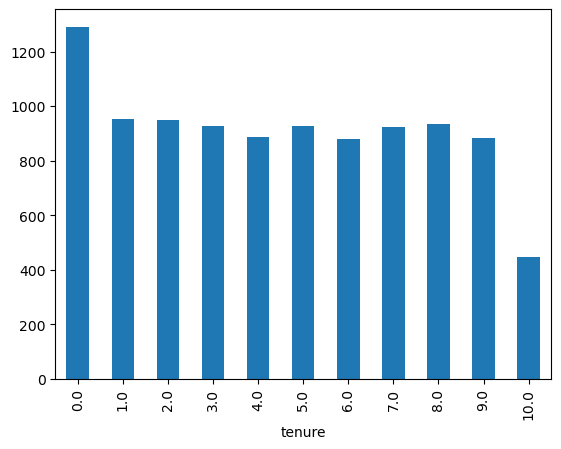

In [16]:
# заполним пропуски нулями
df_zero['tenure'] = df_zero['tenure'].fillna(0)
print(df_zero.isna().sum())
print(df_zero.shape)
df_zero['tenure'].value_counts().sort_index().plot.bar();

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64
(10000, 14)


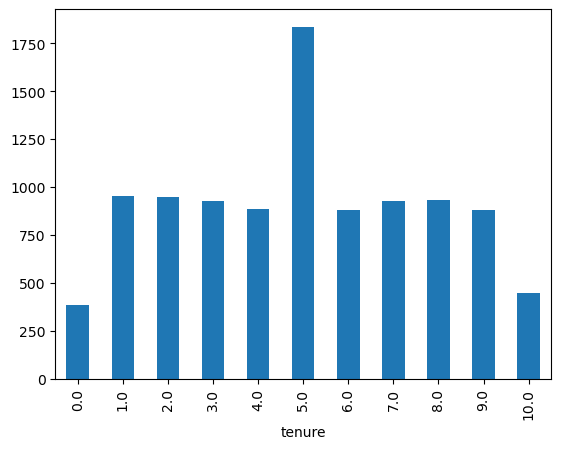

In [17]:
# заполним пропуски медианой
df_median['tenure'] = df_median['tenure'].fillna(df_median['tenure'].median())
print(df_median.isna().sum())
print(df_median.shape)
df_median['tenure'].value_counts().sort_index().plot.bar();

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64
(9091, 14)


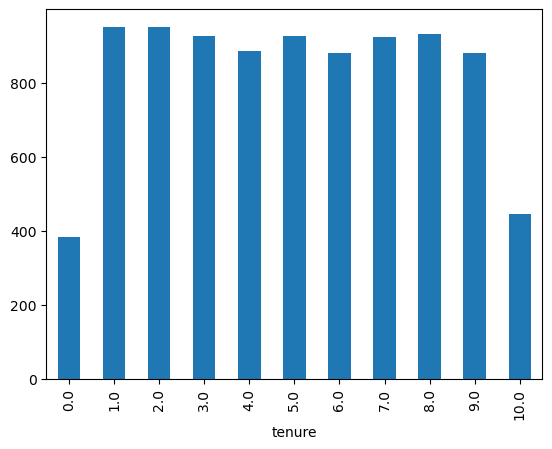

In [18]:
# удалим пропуски
df_drop = df_drop.dropna(subset='tenure')
print(df_drop.isna().sum())
print(df_drop.shape)
df_drop['tenure'].value_counts().sort_index().plot.bar();

### Выводы

- Данные загружены без ошибок. Датафрейм имеет 14 столбцов и 10 000 строк;
- Явные и неявные дубликаты отсутствуют;
- название столбцов приведены к змеиному стилю;
- присутсвует порядка 9.1 % пропусков в столбце 'tenure', для дальнейшей работы были созданы три датафрейма, в которых пропуски были обработаны по разным механизмам:
  - заполнены нулевыми значениями;
  - заполнены медианными значениями;
  - пропуски удалены.

## Исследование задачи

Целевой признак принимет значения 0 или 1, значит перед нами задача бинарной классификации.

### Преобразование полей

Для дальнейшего обучения моделей часть столбцов не несут никакой полезной информации, а именно: 'row_number', 'customer_id', 'surname'. Удалим их из датафреймов.

In [19]:
# создадим функцию для обработка датафреймов
def drop_columns(data, columns_list):
    for column in columns_list:
        data = data.drop([column], axis=1)
    return data

In [20]:
# создадим список столбцов для удаления
columns_list = ['row_number', 'customer_id', 'surname']

In [21]:
# проведем удаление в наших датафреймах
df_zero = drop_columns(df_zero, columns_list)
df_median = drop_columns(df_median, columns_list)
df_drop = drop_columns(df_drop, columns_list)

# проверим
df_zero.shape, df_median.shape, df_drop.shape

((10000, 11), (10000, 11), (9091, 11))

Удаление прошло успешно

In [22]:
# создадим функцию для прямого кодирования категориальных признаков, с учетом дамми-ловушки
def ohe_transform(data):
    data = pd.get_dummies(data, drop_first=True, dtype=int)
    data = clean_columns(data)
    return data

In [23]:
# проведем кодирование в датафреймах
df_zero = ohe_transform(df_zero)
df_median = ohe_transform(df_median)
df_drop = ohe_transform(df_drop)

# посмотри на результат
print(df_zero.shape, df_median.shape, df_drop.shape)
df_zero.columns, df_median.columns, df_drop.columns

(10000, 12) (10000, 12) (9091, 12)


(Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
        'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
        'geography_germany', 'geography_spain', 'gender_male'],
       dtype='object'),
 Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
        'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
        'geography_germany', 'geography_spain', 'gender_male'],
       dtype='object'),
 Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
        'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
        'geography_germany', 'geography_spain', 'gender_male'],
       dtype='object'))

Кодирование категориальных признаков прошло успешно, дамми-ловушку избежали. Закодированные признаки - 'geography' и 'gender'

### Сформируем выборки

In [24]:
# создадим функцию для разделения для наших датафреймов на признаки и целевой признак, 
# разделим на обучающую и валидационную выбокри в пропорции 60/40
def sample_split_60_40(data):
    target_data = data['exited']
    features_data = data.drop(['exited'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features_data,target_data, test_size=0.40, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [25]:
# создадим функцию для разделения валидационной выборки на валидационную и тестовую
def sample_split_60_20_20(feat_valid, targ_valid):
    features_valid, features_test, target_valid, target_test = train_test_split(
    feat_valid, targ_valid, test_size=0.50, random_state=12345)
    return features_valid, features_test, target_valid, target_test

In [26]:
# сформируем выборки для df_zero
features_train_zero, features_valid_zero, target_train_zero, target_valid_zero = sample_split_60_40(df_zero)
features_valid_zero, features_test_zero, target_valid_zero, target_test_zero =\
sample_split_60_20_20(features_valid_zero, target_valid_zero)

# проверим размерность
print(features_train_zero.shape, features_valid_zero.shape, features_test_zero.shape)
target_train_zero.shape, target_valid_zero.shape,target_test_zero.shape

(6000, 11) (2000, 11) (2000, 11)


((6000,), (2000,), (2000,))

In [27]:
# сформируем выборки для df_median
features_train_median, features_valid_median, target_train_median, target_valid_median = sample_split_60_40(df_median)
features_valid_median, features_test_median, target_valid_median, target_test_median =\
sample_split_60_20_20(features_valid_median, target_valid_median)

# проверим размерность
print(features_train_median.shape, features_valid_median.shape, features_test_median.shape)
target_train_median.shape, target_valid_median.shape,target_test_median.shape

(6000, 11) (2000, 11) (2000, 11)


((6000,), (2000,), (2000,))

In [28]:
# сформируем выборки для df_drop
features_train_drop, features_valid_drop, target_train_drop, target_valid_drop = sample_split_60_40(df_drop)
features_valid_drop, features_test_drop, target_valid_drop, target_test_drop =\
sample_split_60_20_20(features_valid_drop, target_valid_drop)

# проверим размерность
print(features_train_drop.shape, features_valid_drop.shape, features_test_drop.shape)
target_train_drop.shape, target_valid_drop.shape,target_test_drop.shape

(5454, 11) (1818, 11) (1819, 11)


((5454,), (1818,), (1819,))

Создали выборки обучающая/валидационная/тестовая в пропорциях 60/20/20.

### Стандартизируем выборки

Количественные признаки сильно различаются по своим масштабам от единиц для 'tenure' до сотен тысяч для финансовых столбцов. Проведем масштабирование данных, методом стандартизации.

In [29]:
# создадим список столбцов с количественными признаками
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [30]:
# создадим функцию для стандартизации количественных признаков
def st_scaler(features_train, features_valid, features_test, numeric):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_valid, features_test

In [31]:
# проведем стандартизацию для набора zero
features_train_zero, features_valid_zero, features_test_zero =\
st_scaler(features_train_zero, features_valid_zero, features_test_zero, numeric)

# проверим что получилось
display(features_train_zero.head())
display(features_valid_zero.head())
features_test_zero.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7479,-0.886751,-0.373192,1.104696,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,1,0,0,1.524268,1,0,0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8532,-0.699824,-0.373192,-0.825373,-1.233163,2,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.503694,-1.233163,1,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.468729,0.438711,1,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.748053,1.239884,1,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.748053,-1.233163,2,1,0,1.358533,0,1,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7041,-2.226392,-0.088482,-0.825373,-1.233163,2,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.426375,-1.233163,1,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.139662,0.722307,1,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.748053,-1.233163,2,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.748053,0.615625,1,0,1,-1.070919,0,0,1


In [32]:
# проведем стандартизацию для набора median
features_train_median, features_valid_median, features_test_median =\
st_scaler(features_train_median, features_valid_median, features_test_median, numeric)

# проверим что получилось
display(features_train_median.head())
display(features_valid_median.head())
features_test_median.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7479,-0.886751,-0.373192,1.082277,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,1,0,0,1.524268,1,0,0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8532,-0.699824,-0.373192,-1.101690,-1.233163,2,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.737696,-1.233163,1,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.829679,0.438711,1,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.810266,1.239884,1,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.810266,-1.233163,2,1,0,1.358533,0,1,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7041,-2.226392,-0.088482,-1.101690,-1.233163,2,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.446272,-1.233163,1,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,-0.009707,0.722307,1,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.810266,-1.233163,2,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.810266,0.615625,1,0,1,-1.070919,0,0,1


In [33]:
# проведем стандартизацию для набора drop
features_train_drop, features_valid_drop, features_test_drop =\
st_scaler(features_train_drop, features_valid_drop, features_test_drop, numeric)

# проверим что получилось
display(features_train_drop.head())
display(features_valid_drop.head())
features_test_drop.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
9344,0.809075,-1.039327,-1.025995,0.554904,1,1,0,0.019508,0,0,0
3796,-1.152518,-1.227561,0.696524,0.480609,1,0,0,0.056167,0,0,1
7462,-0.398853,0.090079,1.385532,-1.237830,1,1,1,0.848738,0,0,1
1508,-0.749875,-0.286389,0.352020,-1.237830,2,1,1,-0.894953,0,0,1
4478,-1.028628,-0.756975,-0.336987,-1.237830,2,0,1,-1.284516,0,0,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7445,-1.369326,0.560665,-0.336987,-1.237830,1,1,0,-0.086537,0,0,0
8620,1.232367,0.090079,1.041028,-1.237830,2,0,1,-0.537457,0,0,0
1714,0.840048,0.560665,0.352020,1.231363,1,0,0,1.070393,1,0,1
5441,1.056856,-0.945210,-1.370498,0.951231,1,1,0,-0.576279,0,0,1
9001,0.406433,-0.662858,0.352020,0.767800,1,1,1,0.662068,0,1,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
5170,1.707279,-0.756975,-0.336987,-1.237830,2,1,1,0.718362,0,0,0
4180,-0.429826,-0.286389,1.730036,0.485538,2,0,0,1.687305,1,0,1
7349,-0.171721,0.278313,0.352020,-0.269213,2,0,1,0.824128,1,0,1
7469,0.385784,-0.380507,1.041028,0.464813,1,1,0,-1.118018,0,0,0
3467,-1.142194,0.278313,-1.370498,0.353837,2,0,1,-0.107642,1,0,0


Провели масштабирование количественных признаков методом стандартизации.

### Исследование моделей на несбалансированных данных

Оценим дисбаланс в таргетных данных

In [34]:
target_list = [target_train_zero, target_train_median, target_train_drop]
for targ in target_list:
    print('-'*20)
    print(targ.value_counts(normalize=1))
    print('-'*20)

--------------------
exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64
--------------------
--------------------
exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64
--------------------
--------------------
exited
0    0.793546
1    0.206454
Name: proportion, dtype: float64
--------------------


Видим, что для всех выборок наблюдается дисбаланс положительных и отрицательных ответов (20 на 80 %). Это надо учесть.

Для начала исследуем работу моделей на несбалансированных данных.

In [35]:
# создадим функцию для исследования моделей, которая на выходе будет давать информацию о качестве модели по параметру F1
# и лучшие подобранные гиперпараметры для конкретной модели
def all_models_f1(features_train, target_train, features_valid, target_valid, class_w):
    
    # модель DecisionTreeClassifier
    best_result_tree = 0
    list_criterion = ['gini', 'entropy']
    for depth_tree in range(1, 50):
        for crit in list_criterion:

            # инициализируем модель с настройкой по глубине, задаваемой в цикле
            model_dt = DecisionTreeClassifier(criterion = crit, random_state=12345, max_depth = depth_tree, class_weight=class_w)
            # обучим модель
            model_dt.fit(features_train, target_train)
            # подготовим прогноз
            predict_dt = model_dt.predict(features_valid)
            # посчитаем точность
            result_dt = f1_score(target_valid, predict_dt)
            # найдем лучшую модель DecisionTreeClassifier
            if result_dt > best_result_tree:
                best_result_tree = result_dt
                best_model_dt = model_dt
    probabilities_dt = best_model_dt.predict_proba(features_valid)
    probabilities_one_test_dt = probabilities_dt[:, 1]
    print('Значение F1 для модели DecisionTreeClassifier:', best_result_tree)
    print('Значение ROC-AUC для модели DecisionTreeClassifier:',
          roc_auc_score(target_valid, probabilities_one_test_dt))
    print(best_model_dt)
    print('-' * 70)
    
    # модель RandomForestClassifier
    best_result_forest = 0
    list_bootstrap = ['False', 'True']

    for depth_forest in range(1, 10):
        for estimator in range(5, 51, 5):
            for sample in range(1, 5):
                for boots in list_bootstrap:
                    # инициализируем модель с настройками, задаваемыми в цикле
                    model_rf = RandomForestClassifier(random_state=12345, max_depth = depth_forest,\
                                                  n_estimators = estimator,min_samples_leaf = sample, class_weight=class_w)
                    # обучим модель
                    model_rf.fit(features_train, target_train)
                    # подготовим прогноз
                    predict_rf = model_rf.predict(features_valid)
                    # посчитаем точность
                    result_rf = f1_score(target_valid, predict_rf)
                    # найдем лучшую модель       
                    if result_rf > best_result_forest:
                        best_result_forest = result_rf
                        best_model_rf = model_rf                     
    probabilities_rf = best_model_rf.predict_proba(features_valid)
    probabilities_one_test_rf = probabilities_rf[:, 1]
    print('Значение F1 для модели RandomForestClassifier:', best_result_forest)
    print('Значение ROC-AUC для модели DecisionTreeClassifier:',
          roc_auc_score(target_valid, probabilities_one_test_rf))
    print(best_model_rf)
    print('-' * 70)
    
    # модель LogisticRegression
    list_solv = ['newton-cg', 'lbfgs', 'liblinear']
    best_result_lr = 0
    for solv in list_solv:
        for it in range(100, 1001, 50):
            # инициализируем модель с настройками, задаваемыми в цикле
            model_lr = LogisticRegression(random_state=12345, solver=solv, max_iter = it, class_weight=class_w)
            # обучим модель
            model_lr.fit(features_train, target_train)
            # подготовим прогноз
            predict_lr = model_lr.predict(features_valid)
            # посчитаем точность
            result_lr = f1_score(target_valid, predict_lr)            
            # найдем лучшую модель 
            if result_lr > best_result_lr:
                        best_result_lr = result_lr
                        best_model_lr = model_lr
    probabilities_lr = best_model_lr.predict_proba(features_valid)
    probabilities_one_test_lr = probabilities_lr[:, 1]
    print('Значение F1 для модели LogisticRegression:', best_result_lr)
    print('Значение ROC-AUC-для модели DecisionTreeClassifier:',
          roc_auc_score(target_valid, probabilities_one_test_lr))
    print(best_model_lr)
    print('-' * 70)

In [36]:
# рассмотрим набор данных где попуски были заполнены нулевыми значениями
print('Оценка качества моделей для данных где пропуски были заполнены нулевыми значениями')
print('*'*70)
all_models_f1(features_train_zero, target_train_zero, features_valid_zero, target_valid_zero, None)

Оценка качества моделей для данных где пропуски были заполнены нулевыми значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5786516853932585
Значение ROC-AUC для модели DecisionTreeClassifier: 0.7899719632952051
DecisionTreeClassifier(max_depth=9, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.5818181818181819
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8442586756513166
RandomForestClassifier(max_depth=8, min_samples_leaf=3, n_estimators=5,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.33389544688026984
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.758730091520031
LogisticRegression(random_state=12345, solver='newton-cg')
-------------------------------------------------------------------

In [37]:
# рассмотрим набор данных где попуски были заполнены медианными значениями
print('Оценка качества моделей для данных где пропуски были заполнены медианными значениями')
print('*'*70)
all_models_f1(features_train_median, target_train_median, features_valid_median, target_valid_median, None)

Оценка качества моделей для данных где пропуски были заполнены медианными значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5696969696969697
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8164631712023421
DecisionTreeClassifier(max_depth=6, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6015037593984962
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8499181884719844
RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=10,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.33108108108108103
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.75880872736951
LogisticRegression(random_state=12345, solver='newton-cg')
-----------------------------------------------------------------

In [38]:
# рассмотрим набор данных где попуски были удалены
print('Оценка качества моделей для данных где пропуски были удалены')
print('*'*70)
all_models_f1(features_train_drop, target_train_drop, features_valid_drop, target_valid_drop, None)

Оценка качества моделей для данных где пропуски были удалены
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5809682804674458
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8449380311712504
DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.5813148788927336
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8688815790684704
RandomForestClassifier(max_depth=7, min_samples_leaf=3, n_estimators=40,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.30400000000000005
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7736632938001718
LogisticRegression(random_state=12345, solver='newton-cg')
------------------------------------------------------------------

Сводное значение F1, для несбалансированных выборок:

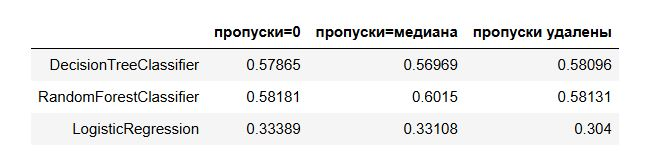

Сводное значение ROC-AUC, для несбалансированных выборок:

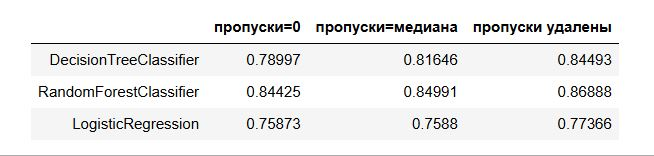

Лучший параметр F1 = 0.6015, при ROC-AUC = 0.84991,  для несбалансированных данных, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены медианными значениями. 


Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=10, random_state=12345)

### Вывод

- Задача представляет сосбой задачу бинарной классификации;
- Данные имею дисбаланс: 80 % - отрицательные ответы;
- Были удалены неиформативные признаки -столбцы: 'row_number', 'customer_id', 'surname';
- Для всех датафреймов были созданы бучающая/валидационная/тестовая выборки (в пропорциях - 60/20/20);
- Проведено масштабирование количественных признаков методом стандартизации;
- Лучший параметр F1 = 0.6015, для несбалансированных данных, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены медианными значениями. Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=10, random_state=12345)

## Борьба с дисбалансом

### Взвешивание классов

Проведем взвешивание классов при помощи встроенного в модели гиперпараметра class_weight.

In [39]:
# рассмотрим набор данных где пропуски были заполнены нулевыми значениями
print('Оценка качества моделей для данных, со взвешенными классами, где пропуски были заполнены нулевыми значениями')
print('*'*70)
all_models_f1(features_train_zero, target_train_zero, features_valid_zero, target_valid_zero, 'balanced')

Оценка качества моделей для данных, со взвешенными классами, где пропуски были заполнены нулевыми значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5984930032292788
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8307537246172549
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6329386437029063
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8556729716487518
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=50, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.4888888888888888
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7634951215528766
Logis

In [40]:
# рассмотрим набор данных где попуски были заполнены медианными значениями
print('Оценка качества моделей для данных, со взвешенными классами, где пропуски были заполнены медианными значениями')
print('*'*70)
all_models_f1(features_train_median, target_train_median, features_valid_median, target_valid_median, 'balanced')

Оценка качества моделей для данных, со взвешенными классами, где пропуски были заполнены медианными значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5984930032292788
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8307537246172549
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6342494714587738
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8576615513038428
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=4,
                       n_estimators=50, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.4888507718696398
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7636811255814515
Log

In [41]:
# рассмотрим набор данных где попуски были удалены
print('Оценка качества моделей для данных, со взвешенными классами, где пропуски были удалены')
print('*'*70)
all_models_f1(features_train_drop, target_train_drop, features_valid_drop, target_valid_drop, 'balanced')

Оценка качества моделей для данных, со взвешенными классами, где пропуски были удалены
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5735449735449736
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8396523192522141
DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6555819477434679
Значение ROC-AUC для модели DecisionTreeClassifier: 0.870116721919828
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       n_estimators=40, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.509731232622799
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7777755279729484
LogisticRegression(class_weight='balanced', random_state=12345,
         

Сводное значение F1, для сбалансированных выборок, методом взвешивания классов:


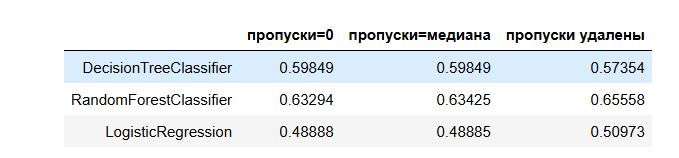

Сводное значение ROC-AUC, для сбалансированных выборок, методом взвешивания классов:


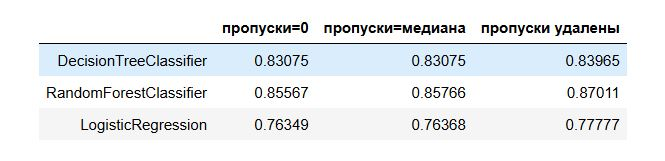

В целом качество моделей улучшилось, по сравнению с несбалансированными данными.


Лучший параметр F1 = 0.65558, при ROC-AUC = 0.87011, для взвешенных классов, был достигнут на выборке, для которой пропуски в исходном датафрейме были удалены. 


Данные по лучшей  модели: RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3, n_estimators=40, random_state=12345)

### Увеличение выборки

Увеличим долю положительных ответов в 4 раза, так как соотношение 0/1 у нас - 80/20

In [42]:
# создадим функцию по увеличению выборки, не забудем про перемешивание
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [43]:
# увеличим выборку для данных zero
features_train_zero_up, target_train_zero_up = upsample(features_train_zero, target_train_zero, 4)

# проверим соотношение
target_train_zero_up.value_counts(normalize=1)

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

In [44]:
# увеличим выборку для данных median
features_train_median_up, target_train_median_up = upsample(features_train_median, target_train_median, 4)

# проверим соотношение
target_train_median_up.value_counts(normalize=1)

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

In [45]:
# увеличим выборку для данных drop
features_train_drop_up, target_train_drop_up = upsample(features_train_drop, target_train_drop, 4)

# проверим соотношение
target_train_drop_up.value_counts(normalize=1)

exited
1    0.509964
0    0.490036
Name: proportion, dtype: float64

Исследуем модели

In [46]:
# рассмотрим набор данных где пропуски были заполнены нулевыми значениями
print('Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были заполнены нулевыми значениями')
print('*'*70)
all_models_f1(features_train_zero_up, target_train_zero_up, features_valid_zero, target_valid_zero, None)

Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были заполнены нулевыми значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5984930032292788
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8306108190831059
DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6310483870967742
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8531770395417344
RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=25,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.4888888888888888
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7634361446657674
LogisticRegression(random_state=12345, solver='newton-cg')
--------------------

In [47]:
# рассмотрим набор данных где попуски были заполнены медианными значениями
print('Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были заполнены медианными значениями')
print('*'*70)
all_models_f1(features_train_median_up, target_train_median_up, features_valid_median, target_valid_median, None)

Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были заполнены медианными значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5984930032292788
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8306108190831059
DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6270491803278689
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8536874164494099
RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=45,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.4888507718696398
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7636191242385932
LogisticRegression(random_state=12345, solver='newton-cg')
------------------

In [48]:
# рассмотрим набор данных где попуски были удалены
print('Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были удалены')
print('*'*70)
all_models_f1(features_train_drop_up, target_train_drop_up, features_valid_drop, target_valid_drop, None)

Оценка качества моделей для данных, с увеличенной выборкой, где пропуски были удалены
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5735449735449736
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8396523192522141
DecisionTreeClassifier(max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6307519640852974
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8679151856303737
RandomForestClassifier(max_depth=9, min_samples_leaf=4, n_estimators=30,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.5085972850678734
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7778583616962137
LogisticRegression(random_state=12345, solver='newton-cg')
---------------------------------------------------------------

Сводное значение F1, для сбалансированных выборок, методом увеличения выборки:

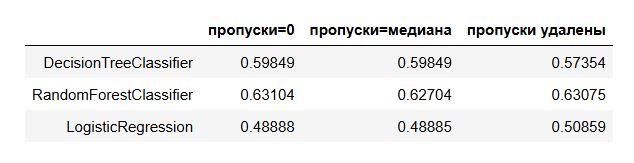

Сводное значение ROC-AUC, для сбалансированных выборок, методом увеличения выборки:


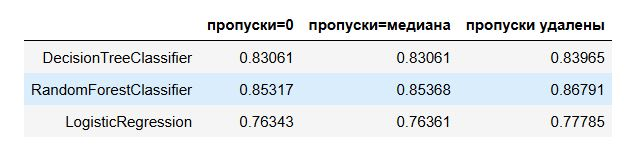

В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра.


Лучший параметр F1 = 0.63104, при ROC-AUC = 0.85317, для увеличенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены нулевыми значениями. 


Данные по лучшей  модели: RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=30, random_state=12345)

### Уменьшение выборки

Уменьшим долю отрицательных ответов в 4 раза, так как соотношение 0/1 у нас - 80/20

In [49]:
# создадим функцию по уменьшению выборки, не забудем про перемешивание
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [50]:
# уменьшим выборку для данных zero
features_train_zero_down, target_train_zero_down = downsample(features_train_zero, target_train_zero, 0.25)

# проверим соотношение
target_train_zero_down.value_counts(normalize=1)

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

In [51]:
# уменьшим выборку для данных median
features_train_median_down, target_train_median_down = downsample(features_train_median, target_train_median, 0.25)

# проверим соотношение
target_train_median_down.value_counts(normalize=1)

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

In [52]:
# уменьшим выборку для данных drop
features_train_drop_down, target_train_drop_down = downsample(features_train_drop, target_train_drop, 0.25)

# проверим соотношение
target_train_drop_down.value_counts(normalize=1)

exited
1    0.509964
0    0.490036
Name: proportion, dtype: float64

In [53]:
# рассмотрим набор данных где пропуски были заполнены нулевыми значениями
print('Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были заполнены нулевыми значениями')
print('*'*70)
all_models_f1(features_train_zero_down, target_train_zero_down, features_valid_zero, target_valid_zero, None)

Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были заполнены нулевыми значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5973397823458283
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8044402034853828
DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6095954844778928
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8550620315874159
RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=25,
                       random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.4892703862660944
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7626361761201071
LogisticRegression(random_state=12345, solver='newton-cg')
--------------------

In [54]:
# рассмотрим набор данных где попуски были заполнены медианными значениями
print('Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были заполнены медианными значениями')
print('*'*70)
all_models_f1(features_train_median_down, target_train_median_down, features_valid_median, target_valid_median, None)

Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были заполнены медианными значениями
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5973397823458283
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8044402034853828
DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6092184368737475
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8354975834598564
RandomForestClassifier(max_depth=4, n_estimators=10, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.48406546080964685
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7622263623660923
LogisticRegression(random_state=12345, solver='newton-cg')
------------------------------------------------------------

In [55]:
# рассмотрим набор данных где попуски были удалены
print('Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были удалены')
print('*'*70)
all_models_f1(features_train_drop_down, target_train_drop_down, features_valid_drop, target_valid_drop, None)

Оценка качества моделей для данных, с уменьшенной выборкой, где пропуски были удалены
**********************************************************************
Значение F1 для модели DecisionTreeClassifier: 0.5667574931880109
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8438142536589497
DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели RandomForestClassifier: 0.6072874493927125
Значение ROC-AUC для модели DecisionTreeClassifier: 0.8653234104668692
RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
----------------------------------------------------------------------
Значение F1 для модели LogisticRegression: 0.5053763440860214
Значение ROC-AUC-для модели DecisionTreeClassifier: 0.7771662399195961
LogisticRegression(random_state=12345, solver='liblinear')
----------------------------------------------------------------------


Сводное значение F1, для сбалансированных выборок, методом уменьшения выборки:


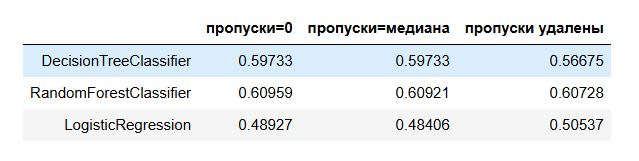

Сводное значение ROC-AUC, для сбалансированных выборок, методом уменьшения выборки:


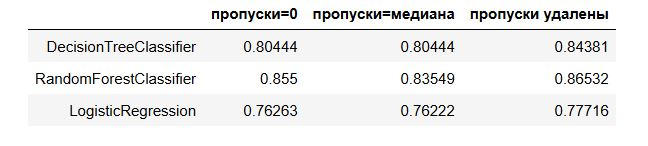

В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра и увеличением выборок.


Лучший параметр F1 = 0.60959, для уменьшенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены нулевыми значениями. 


Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=25, random_state=12345)

### Вывод

- применены три способа борьбы с дисбаласном признаков: настройка гиперпараметра взвешивания классов, увеличение выборок (увеличение доли положительных ответов), уменьшение выборок (уменьшение доли отрицательных ответов);


- настройка гиперпараметра взвешивания классов: В целом качество моделей улучшилось, по сравнению с несбалансированными данными.
  Лучший параметр F1 = 0.6532, для несбалансированных данных, был достигнут на выборке, для которой пропуски в исходном датафрейме были удалены. 
  Данные по лучшей  модели: RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3, n_estimators=25, random_state=12345)


- увеличение выборки: В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра.
  Лучший параметр F1 = 0.63104, для увеличенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены нулевыми значениями. 
  Данные по лучшей  модели: RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=25, random_state=12345)
  
  
-  уменьшение выборки: В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра и увеличением выборок.
   Лучший параметр F1 = 0.60959, для уменьшенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме   были заполнены нулевыми значениями. 
   Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=25, random_state=12345)
   
   
-  **Для финального тестирования: выборки, где пропуски в начальном датафрейме были удалены, модель: RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3, n_estimators=40, random_state=12345)**

## Тестирование модели

Проведем тестирование модели.

In [56]:
# инициализируем модель
model_rf = RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                                  n_estimators=40, random_state=12345)

# обучим модель
model_rf.fit(features_train_drop, target_train_drop)

# получим предсказания модели
predict_rf = model_rf.predict(features_test_drop)

# оценим качество
result_rf = f1_score(target_test_drop, predict_rf)
result_rf

0.6084788029925187

Видим, что метрика F1 получилась выше целевого значения (0.59).

Проверим адекватность модели на метрике accuracy. Для проверки адекватности нашей модели, будем сравнивать уё точность предсказаний с простейшей (dummy) моделью.

In [57]:
# импоритруем модель
from sklearn.dummy  import  DummyClassifier

# инициализируем модель
dummy_clf = DummyClassifier(strategy = 'uniform', random_state = 12345)

# обучим модель
dummy_clf.fit(features_train_drop, target_train_drop)

# проверим точность
print('Точность f1 для простейшей модели:',dummy_clf.score(features_test_drop, target_test_drop))
print('Точность f1 для обученной модели:', f1_score(target_test_drop, predict_rf))

Точность f1 для простейшей модели: 0.5035733919736118
Точность f1 для обученной модели: 0.6084788029925187


Доля правильных ответов в нашей модели выше, проверка на адекватность пройдена.

Теперь посмотрим на параметра AUC-ROC, как известно если 0,5 < AUC < 1, тогда высока вероятность, что классификатор сможет различить положительные и отрицательных значения класса.

In [58]:
probabilities = model_rf.predict_proba(features_test_drop)
probabilities_one_test = probabilities[:, 1]
print('AUC-ROC для обученной модели:', roc_auc_score(target_test_drop, probabilities_one_test))

AUC-ROC для обученной модели: 0.8617651396942949


### Анализ важности признаков

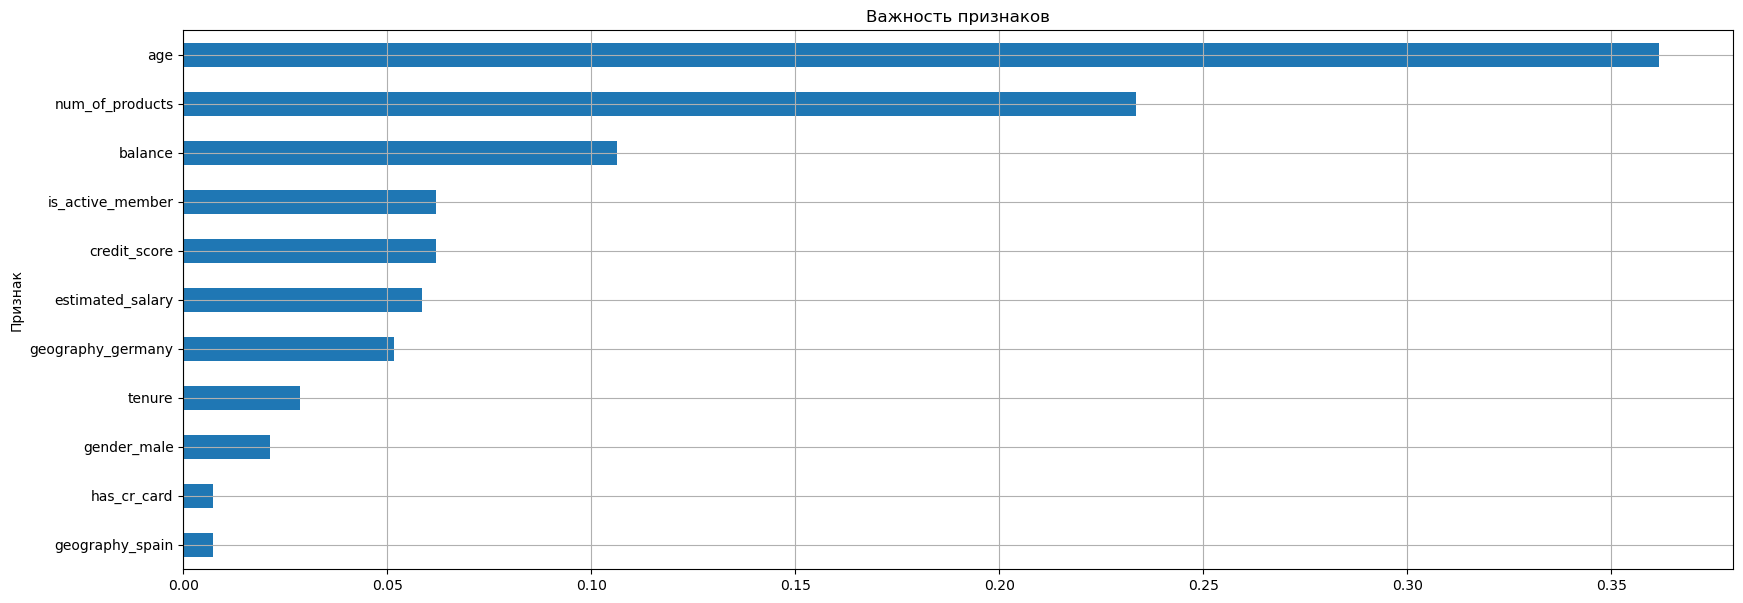

In [59]:
# визуализируем важность признаков
plt.title('Важность признаков')
plt.ylabel('Признак')
pd.Series(model_rf.feature_importances_, index=model_rf.feature_names_in_)\
            .sort_values(ascending=True).plot.barh(figsize=(20,7), grid=True);
plt.show()

Наибольшее влияние оказывают следующие признаки: возраст, количество банковских продуктов и суммарный баланс клиента.

###  Вывод

Тестирование на финальной модели показала метрику F1 = 0.608, AUC-ROC = 0.8617. Так же модель показала свою адекватность по сравнению с простейшей моделью.

## Общий вывод

- Данные загружены без ошибок. Датафрейм имеет 14 столбцов и 10 000 строк;
- Явные и неявные дубликаты отсутствуют;
- название столбцов приведены к змеиному стилю;
- присутсвует порядка 9.1 % пропусков в столбце 'tenure', для дальнейшей работы были созданы три датафрейма, в которых пропуски были обработаны по разным механизмам:
  - заполнены нулевыми значениями;
  - заполнены медианными значениями;
  - пропуски удалены.
  
  
- Задача представляет сосбой задачу бинарной классификации;
- Данные имею дисбаланс: 80 % - отрицательные ответы;
- Были удалены неиформативные признаки -столбцы: 'row_number', 'customer_id', 'surname';
- Для всех датафреймов были созданы бучающая/валидационная/тестовая выборки (в пропорциях - 60/20/20);
- Проведено масштабирование количественных признаков методом стандартизации;
- Лучший параметр F1 = 0.6015, для несбалансированных данных, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены медианными значениями. Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=10, random_state=12345)



- применены три способа борьбы с дисбаласном признаков: настройка гиперпараметра взвешивания классов, увеличение выборок (увеличение доли положительных ответов), уменьшение выборок (уменьшение доли отрицательных ответов);


- настройка гиперпараметра взвешивания классов: В целом качество моделей улучшилось, по сравнению с несбалансированными данными.
  Лучший параметр F1 = 0.65558, при ROC-AUC = 0.87011, для взвешенных классов, был достигнут на выборке, для которой пропуски в исходном датафрейме были удалены. 
  Данные по лучшей  модели: RandomForestClassifier(bootstrap='False', class_weight='balanced', max_depth=8, min_samples_leaf=3, n_estimators=40, random_state=12345)


- увеличение выборки: В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра.
  Лучший параметр F1 = 0.63104, при ROC-AUC = 0.85317, для увеличенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены нулевыми значениями. 
  Данные по лучшей  модели: RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=30, random_state=12345)
  
  
-  уменьшение выборки: В целом качество моделей улучшилось, по сравнению с несбалансированными данными, но немного хуже чем для сбалансированных класов, настройкой гиперпараметра и увеличением выборок.
   Лучший параметр F1 = 0.60959, для уменьшенных выборок, был достигнут на выборке, для которой пропуски в исходном датафрейме были заполнены нулевыми значениями. 
   Данные по лучшей  модели: RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=25, random_state=12345)
   
-  **Для финального тестирования: выборки, где пропуски в начальном датафрейме были удалены, модель: RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3, n_estimators=40, random_state=12345)**



- Тестирование на финальной модели показала метрику F1 = 0.608, AUC-ROC = 0.8617. Так же модель показала свою адекватность по сравнению с простейшей моделью.

Наибольшее влияние оказывают следующие признаки: возраст, количество банковских продуктов и суммарный баланс клиента.